# Introduction

###### Clustering documents using K-means and topic modelling with LDA

# Imports

In [142]:
import glob # To read all files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import spacy
import warnings
import mlflow


from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from spacy.lang.fr import French

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud, ImageColorGenerator
from joblib import load, dump
from pathlib import Path
from nltk.stem.snowball import SnowballStemmer

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
warnings.filterwarnings('ignore')

In [267]:
# Save the path of root and Data directory
ROOT_DIR = Path('.').resolve().parents[0].absolute()
DATA_DIR = ROOT_DIR / 'dataset' / 'documents'

# Create a list of stopwords
STOP_WORDS =  list(fr_stop) + list(en_stop)

# Punctuations to be removed
PUNCTUATIONS = "!#$%&()*+,-./:;<=>?@[\]^_`{|}~//\\«»°" 

# Text preprocessing variables
nlp = spacy.load('fr_core_news_sm')

<https://spacy.io/usage/linguistic-features>

In [254]:
from clustering_model_method_extraction import read_data, tokenize_string, vectorize_tfidf, train_kmeans, similarity_dict, get_outlier_idx,tokenize_string_topic_modelling, remove_nouns, compute_coherence_values, topic_modelling_data_preprocessing

In [187]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Dataset

In [256]:
df = read_data(0)

In [257]:
df.head()

,filename,clauses
0,161102 statuts à jour -OCR_OCR-pdfa,[PDM NETWORKS SOCIETE A RESPONSABILITE LIMITEE...
1,17. Statuts post RK-OCR_OCR-pdfa,[INIFLUX Société par actions simplifiée au cap...
2,2016 06 12 Statuts-OCR_OCR-pdfa,[ICI Société par actions simplifiée au capital...
3,2016 09 29 Statuts modifiés AssurCopro - copie...,[ASSURCOPRO Société par Actions Simplifiée au ...
4,2016 09 29 Statuts modifiés AssurCopro Sud-OCR...,[AssurCopro Sud Société par actions simplifiée...


# Process data

In [258]:
df['processed_clause'] = df['clauses'].apply(lambda text: tokenize_string(text))
df.head()

,filename,clauses,processed_clause
0,161102 statuts à jour -OCR_OCR-pdfa,[PDM NETWORKS SOCIETE A RESPONSABILITE LIMITEE...,pdm network societe responsabilite limitee cap...
1,17. Statuts post RK-OCR_OCR-pdfa,[INIFLUX Société par actions simplifiée au cap...,iniflux sociéter action simplifier capital eur...
2,2016 06 12 Statuts-OCR_OCR-pdfa,[ICI Société par actions simplifiée au capital...,ici sociéter action simplifier capital euro si...
3,2016 09 29 Statuts modifiés AssurCopro - copie...,[ASSURCOPRO Société par Actions Simplifiée au ...,assurcopro sociéter action simplifier capital ...
4,2016 09 29 Statuts modifiés AssurCopro Sud-OCR...,[AssurCopro Sud Société par actions simplifiée...,assurcopro sud société action simplifier capit...


In [259]:
clauses = df['processed_clause']

In [260]:
len(clauses)

646

In [261]:
X, vectorizer = vectorize_tfidf(clauses)

<AxesSubplot:ylabel='Frequency'>

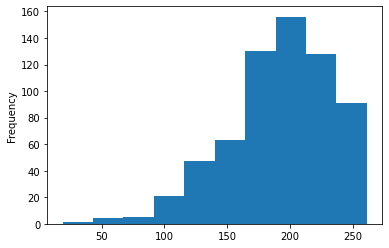

In [262]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(X) 

similarity = similarity_dict(dist)

cosine_series = pd.Series(similarity.values())
cosine_series.plot.hist()

In [263]:
outlier_indexes = get_outlier_idx(100, similarity)
outlier_names = df.iloc[outlier_indexes]['filename'].to_list()

In [264]:
for val in outlier_names:
    df = df.drop(df[df['filename'] == val].index)

len(df)

633

#### Rebuild the tfidf vectorizer without the outliers

In [265]:
clauses = df['processed_clause']

In [ ]:
X, vectorizer = vectorize_tfidf(clauses)

### Dump the vectorizer

In [189]:
dump(vectorizer, (ROOT_DIR / 'models' / 'tfidf_vectorizer.pkl'))

['C:\\Users\\Subaandh\\Desktop\\Hyperlex\\NLP_Document_Clustering\\models\\tfidf_vectorizer.pkl']

In [190]:
feature_names = vectorizer.get_feature_names()
len(feature_names)

771

In [191]:
# doc = 0
# feature_index = X[doc,:].nonzero()[1]
# scores = zip(feature_index, [X[doc, x] for x in feature_index])
# for w, s in [(feature_names[i], s) for (i, s) in scores]:
#     print (w, s)

# Model Training

## Base Model

In [225]:
k = 4
km = train_kmeans(k, X)
df['cluster'] = km.labels_

In [226]:
dump(km, ROOT_DIR / 'models' / 'k_means_clustering.pkl')

['C:\\Users\\Subaandh\\Desktop\\Hyperlex\\NLP_Document_Clustering\\models\\k_means_clustering.pkl']

In [227]:
##### To download <python -m spacy download fr_core_news_sm>

# Evaluation

In [230]:
df['cluster'].value_counts()

1    275
3    216
0     91
2     31
Name: cluster, dtype: int64

## Qualitative Analysis

Sorting getting the closest word near the centroid so that we can know about the category

In [229]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    print('Cluster %d:' % i),
    for j in order_centroids[i, :25]:
        print(feature_names[j], ',' , end = ' ')
    
    print('\n')
    for f in df[df['cluster'] == i]['filename'][:4]:
        print(f, ',', end=' ')
        
    print('\n\n')

Cluster 0:
directeur , conseil , simplifier , émission , dirigeant , domicile , correspondance , compétence , etou , stipulation , membre , acompte , surveillance , ii , administration , élection , versement , prime , pluralité , groupe , relever , initiative , associésarticle , rc , annexe , 

2016 09 29 Statuts modifiés AssurCopro - copie-OCR_OCR , 2016 09 29 Statuts modifiés AssurCopro Sud-OCR_OCR , 2016 09 29 Statuts modifiés Axim Investment-OCR_OCR-pdfa , BizNet.io - Statuts constitutifs-OCR_OCR , 


Cluster 1:
gérant , gérance , conjoint , limité , héritier , époux , acquérir , consentement , notification , rachat , communauté , pluralité , proportion , numéroter , dépôt , agréer , quart , acquéreur , 000 , opposable , associe , demeurer , sarl , survivant , accomplir , 

161102 statuts à jour -OCR_OCR-pdfa , HELENE BLANC - Statuts 160617-OCR_OCR , STATUT DIMTI INSTRU_20160120123017-OCR_OCR , STATUTS  4-OCR_OCR , 


Cluster 2:
actionnaire , directeur , conseil , administration , 

## Quantitative Analysis

<https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>

Text(0, 0.5, 'Distances')

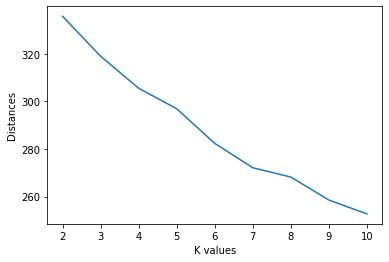

In [235]:
distances = []

k_values = range(2, 11, 1)

for k in k_values:
#     print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    distances.append(km.inertia_)
    
plt.plot(k_values, distances)
plt.xlabel('K values')
plt.ylabel('Distances')

[0.19699942576967427, 0.19910421168474027, 0.1856698898138063, 0.11257617186508433, 0.12454774480786847, 0.11801420907634354, 0.12081431337778385, 0.14589561411295315, 0.13551076309132015]


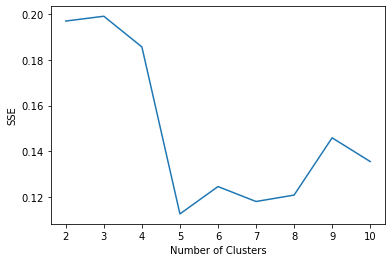

In [237]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_coef = []

for k in range(2, 11):
    km = KMeans(n_clusters=k)
    km.fit(X)
    score = silhouette_score(X, km.labels_)
    silhouette_coef.append(score)

print(silhouette_coef)
plt.plot(range(2, 11), silhouette_coef)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [238]:
experiment_name = 'Document Clustering'

mlflow.set_experiment(experiment_name)

exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

exp_id

'1'

In [239]:
with mlflow.start_run(run_name='Base Model'):
    k = 4
    km = train_kmeans(k, X)
    df['cluster'] = km.labels_
    
    mlflow.log_param('Model', f'K-Means with cluster{k}')
    mlflow.log_param('Vectorizer', 'Tfidf')
    mlflow.sklearn.log_model(km, 'K-Means')
    mlflow.sklearn.log_model(vectorizer, 'K-Means')
    mlflow.log_param('Elbow method', distances)
    mlflow.log_metric('Silhouette max coefficient', max(silhouette_coef))
    mlflow.log_param('Silhoutte coef', silhouette_coef)
    mlflow.log_param('Documents Per Cluster', df['cluster'].value_counts().to_list())

## Detect outliers

In [240]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(X) 

similarity = similarity_dict(dist)

cosine_series = pd.Series(similarity.values())
cosine_series.describe()

count    613.000000
mean     188.749710
std       36.832193
min       92.916838
25%      167.540949
50%      190.695854
75%      216.814836
max      253.714759
dtype: float64

<AxesSubplot:ylabel='Frequency'>

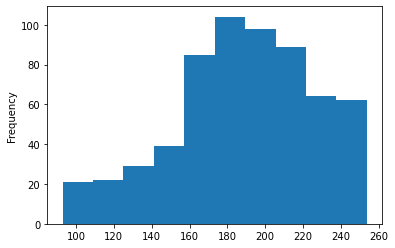

In [241]:
cosine_series.plot.hist()

##### From the similarity we can see that most of the outliers are less than 100 we should visualize it now

In [242]:
outlier_indexes = get_outlier_idx(100, similarity)
df.iloc[outlier_indexes]['filename'].to_list()

['STATUTS 247-OCR_OCR-pdfa',
 'STATUTS MAJ 45-OCR_OCR-pdfa',
 'statuts MAJ 20.12.2016-OCR_OCR',
 'STATUTS 449-OCR_OCR',
 'STATUTS BATIIK _20160115103859-OCR_OCR-pdfa',
 'STATUTS MAJ 63-OCR_OCR-pdfa',
 'LOGOS STATUTS-OCR_OCR-pdfa',
 '17. Statuts post RK-OCR_OCR-pdfa',
 'statuts 235-OCR_OCR-pdfa']

In [243]:
outliers = df.iloc[outlier_indexes]['processed_clause']

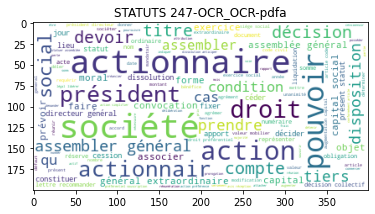

<Figure size 3600x3600 with 0 Axes>

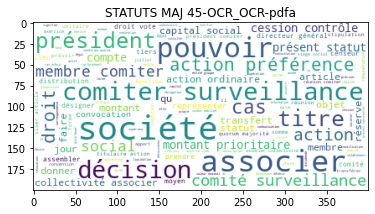

<Figure size 3600x3600 with 0 Axes>

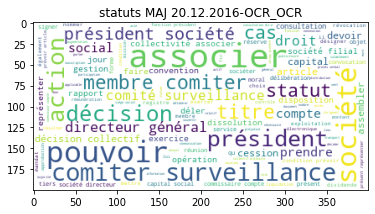

<Figure size 3600x3600 with 0 Axes>

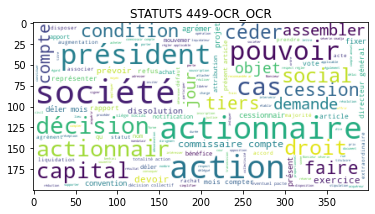

<Figure size 3600x3600 with 0 Axes>

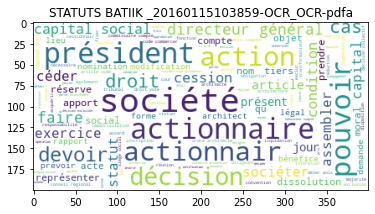

<Figure size 3600x3600 with 0 Axes>

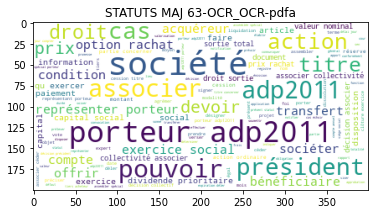

<Figure size 3600x3600 with 0 Axes>

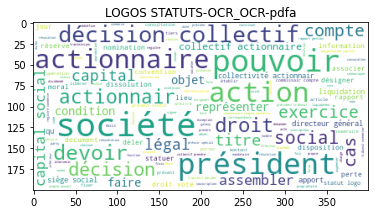

<Figure size 3600x3600 with 0 Axes>

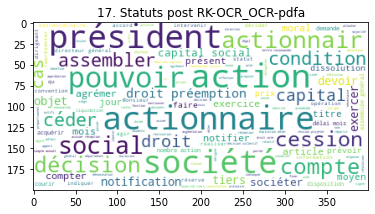

<Figure size 3600x3600 with 0 Axes>

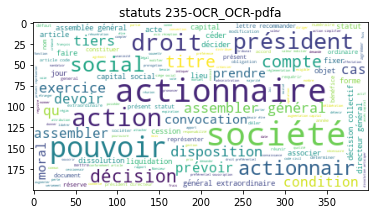

<Figure size 3600x3600 with 0 Axes>

In [209]:
for out in outlier_indexes:
    clauses = df.iloc[out]['processed_clause']
    filename = df.iloc[out]['filename']
    
    doc = nlp(clauses)
    processed_text = [word for word in doc if word.pos_ != 'PROPN' and word.tag_ != 'NNP' and len(word) > 1]
    processed_text = ' '.join(str(word).lower() for word in processed_text)
    
    processed_text = tokenize_string(processed_text)
    
    wordcloud = WordCloud(stopwords=STOP_WORDS , background_color='white', max_font_size=40).generate(processed_text)

    plt.imshow(wordcloud)
    plt.title(filename)
    plt.figure(figsize=(50,50))
    plt.show()

# Predictions

In [248]:
print('Prediction')
y = vectorizer.transform(['associés président'])
predicted = km.predict(y)
print(predicted)

Prediction
[2]


# Topic Modelling

In [249]:
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [266]:
clauses = df['processed_clause']
len(clauses)

633

In [268]:
corpus, dictionary = topic_modelling_data_preprocessing(clauses)

In [269]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [270]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['conseil', 'administration', 'membre', 'directeur', 'administrateur', 'comité', 'surveillance', 'actionnaire', 'stratégique', 'comiter', 'professionnel', 'filial', 'délibération', 'activité', 'médecin', 'chirurgien', 'départemental', 'délibérer', 'direction', 'séance']

['gérer', 'gérance', 'agrément', 'agrémer', 'rachat', 'gérant', 'avis', 'acquérir', 'prix', 'proportion', 'acquéreur', 'notifier', 'notification', 'act', 'posséder', '    ', 'frais', 'qualité', 'copie', 'proposer']

['transfert', 'directeur', 'préférence', 'conseil', 'prix', 'surveillance', 'émission', 'adp', '    ', 'membre', 'ii', 'catégorie', 'stipulation', 'signature', 'simplifier', 'consulter', 'groupe', 'détenir', 'désigne', 'total']

['directeur', 'agrémer', 'actionnaire', 'mobilier', 'émission', 'dirigeant', 'exclusion', 'simplifier', 'notification', 'liquidateur', 'diriger', 'transfert', 'accès', 'prix', 'avis', 'préemption', 'actionnair', 'cessionnair', 'présider', 'prononcer']

['gérer', 'gérance', 'gérant',

In [271]:
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.667594851734274


In [272]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=processed_clause, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3762131976675944


In [281]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_clause, start=2, limit=10)

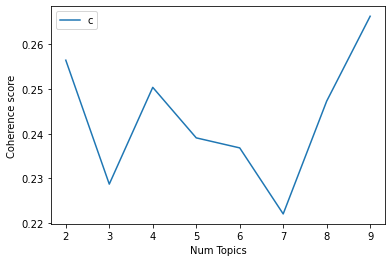

Num Topics = 2  has Coherence Value of 0.2564
Num Topics = 3  has Coherence Value of 0.2287
Num Topics = 4  has Coherence Value of 0.2504
Num Topics = 5  has Coherence Value of 0.2391
Num Topics = 6  has Coherence Value of 0.2368
Num Topics = 7  has Coherence Value of 0.2221
Num Topics = 8  has Coherence Value of 0.2473
Num Topics = 9  has Coherence Value of 0.2662


In [282]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [275]:
### Prediction

new_text_corpus =  dictionary.doc2bow(('directeur dirig actionnair émiss prix, échoirrachat').split())
lda[new_text_corpus]

[(0, 0.051470164),
 (1, 0.050662734),
 (2, 0.051138747),
 (3, 0.7960462),
 (4, 0.050682135)]

### Implemented a synchronous model serving strategy for asynchronous for async implementation we can use